# décrire le problème [TO DO]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [14]:
class Dataset_1D(Dataset):
    def __init__(self, nb_points_in_omega, upper_bound=np.pi):
        self.nb_points_in_omega = nb_points_in_omega
        self.upper_bound = upper_bound
        self.points = torch.FloatTensor(np.linspace(0, np.pi, self.nb_points_in_omega)).reshape(self.nb_points_in_omega, 1)
        self.boundary_points = torch.FloatTensor([self.points[0], self.points[-1]]).reshape(2,1)
        self.labels = self._stratify_points(6)
           
    def __getitem__(self, index):   
        return self.points[index]
    
    def __len__(self):
        return self.nb_points_in_omega
    
    def _stratify_points(self, div):
        labels = np.zeros(self.nb_points_in_omega, dtype=int)
        quotient = self.nb_points_in_omega // div
        for i in range(div):
            if i!= div-1 :
                labels[i*quotient:(i+1)*quotient] = i
            else :
                labels[i*quotient:] = i
        return labels
    
def create_train_val_dataset(dataset, val_size=0.2):

    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=val_size, random_state=6, stratify=dataset.labels)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    return train_dataset, val_dataset

In [6]:
class ActivationCube(torch.nn.Module):
    def __init__(self) -> None:
        super(ActivationCube, self).__init__()

    def forward(self, x):
        return torch.maximum(x**3, torch.tensor(0.))

class RitzModel(torch.nn.Module):

    def __init__(self):
        super(RitzModel, self).__init__()

        self.fc1 = torch.nn.Linear(in_features=1, out_features=10)
        self.activation1 = ActivationCube()
        self.fc2 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation2 = ActivationCube()

        self.fc3 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation3 = ActivationCube()
        self.fc4 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation4 = ActivationCube()

        self.fc5 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation5 = ActivationCube()
        self.fc6 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation6 = ActivationCube()

        self.fc7 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation7 = ActivationCube()
        self.fc8 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation8 = ActivationCube()

        self.fc9 = torch.nn.Linear(in_features=10, out_features=1)

        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self, x):
        retain_x1 = x
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = x + retain_x1

        retain_x2 = x
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = x + retain_x2

        retain_x3 = x
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = x + retain_x3

        retain_x4 = x
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = x + retain_x4

        u_theta = self.fc9(x)

        return u_theta

In [7]:
def u_true(x):
    return np.sin(x)**2

def f_true(x):
    return np.sin(2*x) + 2*x*np.cos(2*x)

In [16]:
vxn  = 50
X = Dataset_1D(vxn)
ix = X.points

In [19]:
batch_size_train = 20
batch_size_val = 10
train_dataset, val_dataset = create_train_val_dataset(X, val_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

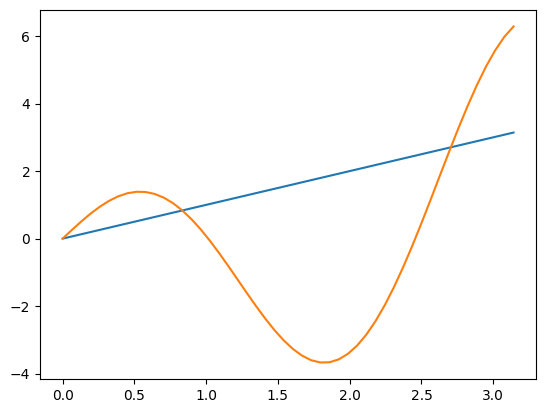

In [20]:
plt.plot(ix, ix)
plt.plot(ix, f_true(ix))

In [21]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = torch.nn.Linear(1,80)
        self.mi  = torch.nn.Linear(80,80)
        self.mi1  = torch.nn.Linear(80,80)
        self.mi2 = torch.nn.Linear(80,40)
        self.ol  = torch.nn.Linear(40,1)

        self.tn  = torch.nn.Tanh()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x):
        u = x
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =  self.ol(self.tn(hidden3))
        return out

In [25]:
boundary = X.boundary_points
true_boundary = torch.FloatTensor([0., 0.]).reshape(2,1) # homogeneous boundary condition

pred_boundary_ritz = np.array([])
pred_boundary_net = np.array([])

ritz_model = RitzModel()
net_model = Net()

for _ in range(100) :
    pred_boundary_ritz = np.append(pred_boundary_ritz, ritz_model(boundary).detach().numpy())
    pred_boundary_net = np.append(pred_boundary_net, net_model(boundary).detach().numpy())

print(np.mean(pred_boundary_ritz), np.mean(pred_boundary_net))

0.6650475785136223 0.04483611136674881


In [22]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def Du(x, model):
    u = model(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0]
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0]
    return u_xx

In [301]:
import random

nb_batch = 20
batches_list = []
f_batches_list = []

for _ in range(nb_batch) :
    batch = np.array(random.choices(vx, k=10))
    batch = torch.FloatTensor(batch).reshape(10,1)
    batch.requires_grad = True
    batches_list.append(batch)

    f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(10,1)
    f_batch.requires_grad = True
    f_batches_list.append(f_batch)

print(Du(batches_list[0], net_model))

tensor([[0.0369],
        [0.0320],
        [0.0338],
        [0.0288],
        [0.0314],
        [0.0395],
        [0.0380],
        [0.0314],
        [0.0395],
        [0.0377]], grad_fn=<AddBackward0>)


In [28]:
# VERSION WITH DATALOADER

net_model = Net()
epochs = 1000
loss_fn = torch.nn.MSELoss()
optimizer_f = torch.optim.Adam(net_model.parameters(), lr=0.0005)
optimizer_boundary = torch.optim.Adam(net_model.parameters(), lr=0.001)

for epoch in range(epochs):
    net_model.train()
    for batch in train_loader:
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(batch_size_train,1)
        f_batch.requires_grad = True

        optimizer_f.zero_grad()
        optimizer_boundary.zero_grad()

        output_boundary = net_model(X.boundary_points)
        output_f = Du(batch, net_model)

        loss_boundary = loss_fn(output_boundary, true_boundary)
        loss_f = loss_fn(output_f, f_batch)

        loss_f.backward()
        loss_boundary.backward()
        optimizer_f.step()
        optimizer_boundary.step()

    net_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val in val_loader:
            f_batch_val = torch.FloatTensor(f_true(batch_val.detach().numpy())).reshape(batch_size_val,1)
            val_loss += np.abs(net_model(batch_val) - f_batch_val)

    val_loss = val_loss.mean()
    # print(f"Epoch {epoch+1} : Validation Loss {val_loss}")

    if epoch % 10 == 0 :
        print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')
        

Epoch 0 : Loss boundary 0.012736772187054157 Loss f 6.6831955909729
Epoch 10 : Loss boundary 0.12347903102636337 Loss f 0.8884882926940918
Epoch 20 : Loss boundary 0.02208179235458374 Loss f 1.2128134965896606
Epoch 30 : Loss boundary 0.0030603271443396807 Loss f 0.24130980670452118
Epoch 40 : Loss boundary 0.0028140745125710964 Loss f 0.11191264539957047
Epoch 50 : Loss boundary 0.0005221934407018125 Loss f 0.04948075860738754
Epoch 60 : Loss boundary 0.0010359255829825997 Loss f 0.0505317747592926
Epoch 70 : Loss boundary 0.00023175706155598164 Loss f 0.034916602075099945
Epoch 80 : Loss boundary 0.0002609996881801635 Loss f 0.040812112390995026
Epoch 90 : Loss boundary 0.00023284080089069903 Loss f 0.022226955741643906
Epoch 100 : Loss boundary 0.00045599541044794023 Loss f 0.01257237233221531
Epoch 110 : Loss boundary 0.0002437210496282205 Loss f 0.02160058543086052
Epoch 120 : Loss boundary 0.0001226300810230896 Loss f 0.020208219066262245
Epoch 130 : Loss boundary 0.0001079570793

In [304]:
net_model = RitzModel()
epochs = 1000
loss_fn = torch.nn.MSELoss()
optimizer_f = torch.optim.Adam(net_model.parameters(), lr=0.0005)
optimizer_boundary = torch.optim.Adam(net_model.parameters(), lr=0.001)

for epoch in range(epochs) :
    for _ in range(nb_batch) :
        batch_index = np.random.randint(0, nb_batch)
        batch = batches_list[batch_index]
        f_batch = f_batches_list[batch_index]

        optimizer_f.zero_grad()
        optimizer_boundary.zero_grad()

        output_boundary = net_model(boundary)
        output_f = Du(batch, net_model)

        loss_boundary = loss_fn(output_boundary, true_boundary)
        loss_f = loss_fn(output_f, f_batch)

        loss_f.backward(retain_graph=True)
        loss_boundary.backward(retain_graph=True)
        optimizer_f.step()
        optimizer_boundary.step()

    if epoch % 10 == 0 :
        print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')

Epoch 0 : Loss boundary 0.8199030160903931 Loss f 5.126681327819824
Epoch 10 : Loss boundary 0.04378104582428932 Loss f 4.421969413757324
Epoch 20 : Loss boundary 0.2733089327812195 Loss f 0.4368392825126648
Epoch 30 : Loss boundary 0.0770147517323494 Loss f 0.39675620198249817
Epoch 40 : Loss boundary 0.000892563140951097 Loss f 0.01837782934308052
Epoch 50 : Loss boundary 0.000870540039613843 Loss f 0.020006829872727394
Epoch 60 : Loss boundary 8.915346552385017e-05 Loss f 0.0048381672240793705
Epoch 70 : Loss boundary 0.0002018957311520353 Loss f 0.019978871569037437
Epoch 80 : Loss boundary 0.0022490806877613068 Loss f 0.03361421078443527
Epoch 90 : Loss boundary 0.0007063833763822913 Loss f 0.009801182895898819
Epoch 100 : Loss boundary 1.9976809198851697e-05 Loss f 0.0037427577190101147
Epoch 110 : Loss boundary 0.0003328870516270399 Loss f 0.0021538534201681614
Epoch 120 : Loss boundary 2.3983506252989173e-05 Loss f 0.0014280888717621565
Epoch 130 : Loss boundary 1.8155412817577

[0.0001321]


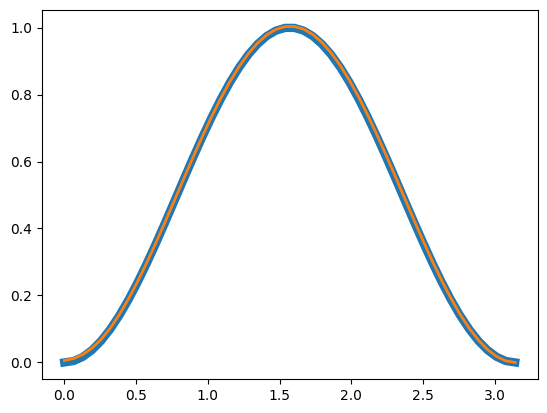

In [29]:
# ix = torch.FloatTensor(vx).reshape(vxn,1)
u = net_model(ix)
plt.plot(ix, u_true(ix) ,  linewidth=6)
plt.plot(ix, u.detach().numpy(), linewidth=2)
print(min(abs(u.detach().numpy() - u_true(ix).detach().numpy())))